In [1]:
import torch
import numpy as np
import pandas as pd

from torch import nn
from torch import optim
from tqdm import tqdm, trange, tqdm_notebook
from torch.nn import functional as F
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn import model_selection as ms
from torchvision import datasets, transforms

In [2]:
train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

In [3]:
batch_size = 128
train_data = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_data = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [4]:
dataset = fetch_openml('mnist_784')
x = np.array(dataset['data'])
y = np.array(dataset['target'], dtype='int32')
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.25, random_state=1)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 10)
        
    def forward(self, input):
        input = F.relu(self.l1(input))
        return F.log_softmax(self.l2(input), dim=1)

In [6]:
EPOCHS = 5
net = Net()
opt = optim.Adam(net.parameters(), lr = 0.001)

for epoch in range(EPOCHS):
    i = 0
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = torch.Tensor(x_train[low: low + batch_size]).float()
        y = torch.Tensor(y_train[low: low + batch_size]).long()
        opt.zero_grad()
        output = net(x)
        #  https://discuss.pytorch.org/t/does-nllloss-handle-log-softmax-and-softmax-in-the-same-way/8835
        loss = F.nll_loss(output, y)
        loss.backward()
        opt.step()
    print(loss)

tensor(0.2775, grad_fn=<NllLossBackward>)
tensor(0.0637, grad_fn=<NllLossBackward>)
tensor(0.0985, grad_fn=<NllLossBackward>)
tensor(0.0974, grad_fn=<NllLossBackward>)
tensor(0.0799, grad_fn=<NllLossBackward>)


In [7]:
print(output.shape)

torch.Size([128, 10])


In [8]:
layer = net.l1.state_dict()
print(layer['weight'])
print(layer['bias'].shape)

tensor([[-0.0046,  0.0137,  0.0098,  ...,  0.0022,  0.0335,  0.0007],
        [-0.0217,  0.0274, -0.0286,  ...,  0.0220, -0.0243,  0.0191],
        [ 0.0049, -0.0104,  0.0142,  ...,  0.0043, -0.0292,  0.0122],
        ...,
        [ 0.0229,  0.0096,  0.0229,  ..., -0.0090, -0.0182, -0.0134],
        [-0.0068,  0.0161,  0.0089,  ..., -0.0014,  0.0089,  0.0119],
        [ 0.0091,  0.0253,  0.0238,  ...,  0.0297, -0.0180, -0.0199]])
torch.Size([128])


In [9]:
total = 0
correct = 0

with torch.no_grad():
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = torch.Tensor(x_train[low: low + batch_size]).float()
        y = torch.Tensor(y_train[low: low + batch_size]).long()
        output = net(x)
        correct += int(torch.sum(y == torch.argmax(output, axis = 1)))
        total += batch_size

print(f"Accuracy: {correct/total * 100}%")

Accuracy: 97.52667682926828%


In [10]:
outputs = []
with torch.no_grad():
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = torch.Tensor(x_train[low: low + batch_size]).float()
        y = torch.Tensor(y_train[low: low + batch_size]).long()
        output = net(x)
        outputs.extend(list(torch.max(output, 1)[0]))
outputs = np.array(outputs)

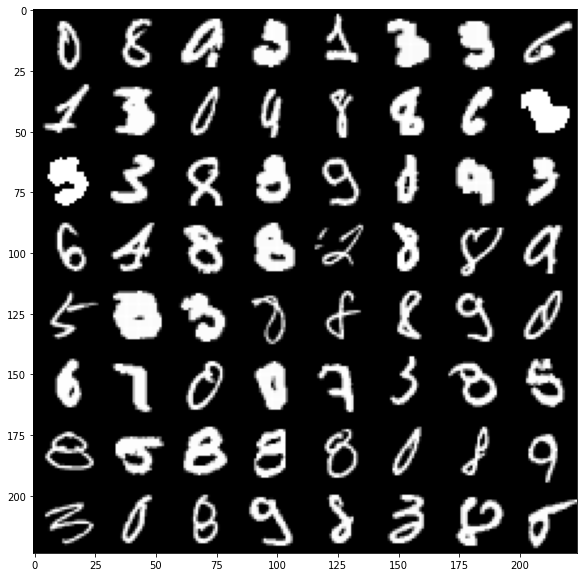

In [11]:
sorted_list = sorted(list(zip(outputs, range(outputs.shape[0]))))
x_bad = x_train[[x[1] for x in sorted_list[:64]]].reshape(8, 28*8, 28)

# let's take a look at the most weird image
plt.figure(figsize=(10, 10))
plt.imshow(np.concatenate(x_bad, axis=1), cmap='gray')

In [12]:
# References
# https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65
# https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/
# https://stackoverflow.com/questions/65192475/pytorch-logsoftmax-vs-softmax-for-crossentropyloss
# https://stats.stackexchange.com/questions/223256/does-the-cross-entropy-cost-make-sense-in-the-context-of-regression#:~:text=In%20general%2C%20you%20can%20define,to%20a%20squared%20Mahalanobis%20distance.&text=So%20yes%2C%20cross%2Dentropy%20can%20be%20used%20for%20regression.
# https://stackoverflow.com/questions/35304393/trying-to-understand-code-that-computes-the-gradient-wrt-to-the-input-for-logsof
# https://cs231n.github.io/optimization-2/
# https://forums.fast.ai/t/05-pet-breeds-understanding-nll-loss-function/84873/3
# https://www.kaggle.com/dansbecker/what-is-log-loss
# https://stackoverflow.com/questions/20027598/why-should-weights-of-neural-networks-be-initialized-to-random-numbers
# https://www.deeplearning.ai/ai-notes/initialization/
# https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65

In [13]:
def init_layer(x, y):
    # TODO: use a better way for initializing weights
    # he - 92%
    # return np.random.randn(x, y) * np.sqrt(2./x)
    # xavier - 93%
    # return np.random.randn(x, y) * np.sqrt(1./x)
    # uniform - 97-98%
    weights = np.random.uniform(-1., 1., size=(x,y))/np.sqrt(x*y)
    bias = np.zeros((1, y))
    return weights, bias
    
def relu(input):
    return np.maximum(input, 0)

"""
def log_softmax(x):
    # invalid value encountered in multiply warning due to underflow/overflow
    sumx = np.sum(np.exp(x), axis=1).reshape(-1, 1)
    return x-np.log(sumx)
"""

def log_softmax(x):
    # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    # https://stackoverflow.com/questions/61567597/how-is-log-softmax-implemented-to-compute-its-value-and-gradient-with-better
    # https://www.youtube.com/watch?v=pZbkVup7fYE
    # https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/
    # https://blog.feedly.com/tricks-of-the-trade-logsumexp/
    c = x.max(axis=1)
    return x - (c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))).reshape((-1, 1))

learning_rate = 0.001

In [29]:
def forward(x):
    x_l1 = x.dot(l1) + b1
    x_relu = relu(x_l1)
    x_l2 = x_relu.dot(l2) + b2
    y_pred = log_softmax(x_l2)
    return y_pred

def forward_backward(x, y):
    """
    Some dimensional analysis:
    x = input image of shape: batch_size * 784
    y = true output for the images of shape: batch_size * 10
    l1 = weights of layer 1 w shape: 784 * 128
    l2 = weights of layer 2 w shape: 128 * 10
    b1 = bias of layer 1 w shape: 1 * 128
    b2 = bias of layer 1 w shape: 1 * 10
    
    x_l1 = the dot product of x and l1 of shape: batch_size * 128
    x_relu = the ReLU activation function applied on x_l1 of shape: batch_size * 128
    x_l2 = the dot product of x_relu and l2 of shape: batch_size * 10
    y_pred = the log-softmax function applied on x_l2 of shape: batch_size * 10
    y_mod = one-hot encoding of y of shape: batch_size * 10
    y_pred = output of the neural network of shape: batch_size * 10
    loss = loss of the network of shape: batch_size
    
    d_ypred = derivative of loss WRT y_pred of shape: batch_size * 10
    d_lsm = derivative of the y_pred WRT x_l2 of shape: batch_size * 10
    d_l2 = derivative of x_l2 WRT l2 of shape: 128 * 10
    
    d_relu = derivative of loss WRT x_l2 of shape: batch_size * 128
    d_xl1 = derivative of ReLU WRT to x_l1 of shape: batch_size * 128
    d_l1 = derivative of x_l1 WRT l1 of shape: 784 * 128
    
    d_l2 = derivative of nll_loss * derivative of lsm * x_relu of shape: 128 * 10
    d_l1 = derivative of y_pred wrt x_relu * derivative of x_relu * x of shape: 784 * 128
    """
    y_mod = np.zeros((len(y), 10))
    y_mod[range(len(y)), y] = 1
    
    x_l1 = x.dot(l1) + b1
    x_relu = relu(x_l1)
    x_l2 = x_relu.dot(l2) + b2
    y_pred = log_softmax(x_l2)
    loss = (-y_mod * y_pred).mean(axis=1)
    
    # derivative of loss wrt y_pred
    d_ypred = -(y_mod / len(y))
    # derivative of log-softmax
    d_lsm = d_ypred - (np.exp(y_pred) * d_ypred.sum(axis=1).reshape((-1, 1)))
    # derivative of layer 2 weights
    d_l2 = x_relu.T.dot(d_lsm)
    d_b2 = d_lsm.mean(axis=0)
    
    # derivative of x_l2 wrt to loss
    d_relu = d_lsm.dot(l2.T)
    # derivative of relu
    d_xl1 = (x_relu > 0).astype('float32') * d_relu
    # derivative of layer 1 weights
    d_l1 = x.T.dot(d_xl1)
    d_b1 = d_xl1.mean(axis=0)
    
    return y_pred, d_l1, d_l2, d_b1, d_b2, loss

In [42]:
EPOCHS = 6
batch_size = 128
learning_rate = 0.001

l1, b1 = init_layer(28*28, 128)
l2, b2 = init_layer(128, 10)

losses = []
accuracies = []

for epoch in trange(EPOCHS):
    for i in range(1000):
        idx = np.random.randint(0, x_train.shape[0], size=batch_size)
        x = x_train[idx]
        y = y_train[idx]
        y_pred, d_l1, d_l2, d_b1, d_b2, loss = forward_backward(x, y)
        l1 -= learning_rate * d_l1
        l2 -= learning_rate * d_l2
        b1 -= learning_rate * d_b1
        b2 -= learning_rate * d_b2
        losses.append(loss.mean())
        accuracy = (y == np.argmax(y_pred, axis=1)).mean()
        accuracies.append(accuracy)

100%|██████████| 6/6 [00:15<00:00,  2.55s/it]


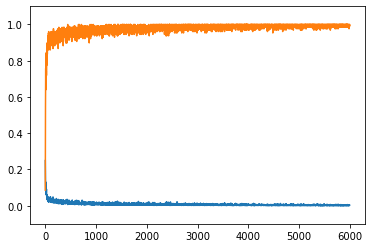

In [43]:
plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [44]:
out = forward(x_test)
out = np.argmax(out, axis=1)
print((y_test == out).mean() * 100)

97.69142857142857
